This script loads raw neuropixel spike times and prepares data for further analysis by performing the following steps:
1. Select which task entries to analyze
2. Load behavioral data and select good trials based on the reach time distributions.
3. Load neuropixel spike times
    - Bin spike times
    - Align data to the even of interest
    - Smooth timeseries with a Gaussian kernel
4. Saves preprocessed data
5. Plots basic neural data figures
    - Trial averaged firing rate
    - Raster plots
    - Raster plots organized by target direction

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
import multiprocessing as mp
import time
import glob
from datetime import date

In [32]:
# Paths
data_path_preproc = '/media/moor-data/preprocessed.new/'
data_path_raw = '/media/moor-data/raw/neuropixels/'
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
behavior_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/behavior"

# General data parameters
subject = 'beignet'
task_coords = 'yzx'
task_perturb = None
task_rotation = 0

# Task event code definitions
task_codes = aopy.data.bmi3d.load_bmi3d_task_codes()
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239

# # Select which event to align to
# # align_event = 'TARGET ONSET'
# # align_event = 'GO CUE'
# align_event = 'MOVEMENT ONSET'
# # align_event = 'ENTER TARGET'
# END_TRIAL_CODE = REWARD


# Trial selection parameters
trial_filter = lambda t: CENTER_TARGET_OFF in t
success_rate_window = 19
reach_time_std_thresh = 3

# Neuropixel data parameters
implant_name = ['NP_Insert72', 'NP_Insert137']
start_date = '2023-07-13'
end_date = date.today()
elec_config = 'bottom'
spike_bin_width_mc = 0.01 #[s]
smooth_width = 150
smooth_nstd = 3

# Task data selection parameters
tbefore_mc = 0.2
tafter_mc = .8

# Quality metrics for unit selection
min_trial_prop = 0.75

# Visualization parameters
colors = sn.color_palette(n_colors=9)

In [3]:
def get_cursor_leave_center_time(data, samplerate, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        samplerate
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    
    for itr in range(ntr):
        t_axis = np.arange(data[itr].shape[0])/samplerate
        
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx = np.where(dist>target_radius)[0]
        temp = t_axis[leave_idx]
        cursor_leave_center_time.append(temp[0])
    
    return cursor_leave_center_time

def get_cursor_leave_center_idx(data, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius. Nan if cursor doesn't leave center target.
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    leave_idx = []
    for itr in range(ntr):
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        
        try:
            temp_leave_idx = np.where(dist>target_radius)[0][0]
        except:
            temp_leave_idx = np.nan
        leave_idx.append(temp_leave_idx)
    
    return leave_idx

def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')

# Select relevant task entries

In [4]:
# if align_event == 'TARGET ONSET':
#     START_TRIAL_CODE = PERIPHERAL_TARGET_ON
#     START_TRIAL_CODE_BEHAVIOR = PERIPHERAL_TARGET_ON
#     align_movement_onset = False
# elif align_event == 'GO CUE':
#     START_TRIAL_CODE = CENTER_TARGET_OFF
#     START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
#     align_movement_onset = False
# elif align_event == 'MOVEMENT ONSET':
#     START_TRIAL_CODE = CENTER_TARGET_OFF
#     START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
#     align_movement_onset = True
# elif align_event == 'ENTER TARGET':
#     START_TRIAL_CODE = CURSOR_ENTER_PERIPHERAL_TARGET
#     START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
#     align_movement_onset = False

In [5]:
# Load neuropixel center-out task data
# bad_tes = [13152, 13153, 13154, 13155, 13156, 13272]
bad_tes = [13152, 13153, 13154, 13155, 13156,13102, 13272, 12290, 12291] # Also remove recording at site 48
# bad_tes = [13102,13152, 13153, 13154, 13155, 13156, 13272, 9940, 9958, 10812, 10820, 12290, 12291]
mc_entries =  db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
mc_entries = [me for me in mc_entries if 'neuropixel_port1_drive_type' in me.task_params and me.task_params['neuropixel_port1_drive_type'] in implant_name
             and me.task_params['rotation']==task_coords and me.entry_name != 'flash']

# Remove bad TE IDs
mc_entries = [me for me in mc_entries if me.id not in bad_tes]
dates = np.unique([me.date.date() for me in mc_entries])

print(mc_entries, '\n','\n', dates)

[2023-07-13 13:06:46.567495: beignet on manual control task, id=9923, 2023-07-13 13:09:07.735090: beignet on manual control task, id=9924, 2023-07-13 13:41:06.548415: beignet on manual control task, id=9925, 2023-07-14 12:10:54.765135: beignet on manual control task, id=9928, 2023-07-14 13:12:04.967348: beignet on manual control task, id=9931, 2023-07-18 14:56:35.442092: beignet on manual control task, id=9940, 2023-07-19 11:49:20.267279: beignet on manual control task, id=9958, 2023-08-28 14:03:24.447446: beignet on manual control task, id=10802, 2023-08-29 15:21:49.044992: beignet on manual control task, id=10812, 2023-08-30 12:01:38.097517: beignet on manual control task, id=10820, 2023-08-31 13:12:42.458972: beignet on manual control task, id=10828, 2023-09-01 11:55:47.553120: beignet on manual control task, id=10835, 2023-11-16 13:24:31.399857: beignet on manual control task, id=12269, 2023-12-28 13:25:30.554051: beignet on manual control task, id=13122, 2024-01-03 14:56:35.152260

# Load behavioral data

In [6]:
subjects = [subject for me in mc_entries]
te_ids = [me.id for me in mc_entries]
me_dates = [me.date.date() for me in mc_entries]
df = aopy.data.bmi3d.tabulate_behavior_data_center_out(data_path_preproc, subjects, te_ids, me_dates, metadata=['target_radius'])
df['reward'] = df['reward'].astype(bool)
success_rate = aopy.analysis.calc_success_rate_trials(df['reward'], df['reach_completed'], window_size=success_rate_window)
success_rate_date_labels = df['date']
df = df[df['reward']].reset_index(drop=True)

# Add cursor trajectories
traj_times = np.array([(hst-tbefore_mc, e[-1]+tafter_mc) for hst, e in zip(df['hold_start_time'], df['event_times'])])
df['cursor_traj'] = aopy.data.bmi3d.tabulate_kinematic_data(data_path_preproc, df['subject'], df['te_id'], df['date'], traj_times[:,0], traj_times[:,1], datatype='cursor')
df['start_time'] = traj_times[:,0]

# Add behavior metrics
df['duration'] = [(t[-1]-t[0])- (tbefore_mc+tafter_mc) for t in traj_times] 
cursor_traj = [np.array(t) for t in df['cursor_traj']]
df['cursor_vel_traj'] = [np.array([aopy.utils.derivative(np.arange(len(t))/1000, t[:,0]), aopy.utils.derivative(np.arange(len(t))/1000, t[:,1])]).T for t in cursor_traj]
df['cursor_vel'] =  [np.mean(aopy.utils.derivative(np.arange(len(t))/1000, t)) for t in cursor_traj]

  0%|          | 0/18 [00:00<?, ?it/s]

In [7]:
# Get specs of loaded data
reach_times = np.array(df['duration'][df['reward']])
n_mctrials = [len(df[(df['date']==date)*df['reward']]) for date in dates]
ntargets = len(np.unique(np.array(df['target_idx'][df['reward']])))
unique_targets = aopy.data.bmi3d.get_target_locations(data_path_preproc, subject, df['te_id'][0], df['date'][0], np.unique(df['target_idx']))
reach_time_thresh = np.median(np.hstack(reach_times)) + (np.median(np.hstack(reach_times))-np.min(np.hstack(reach_times)))
good_trial_idx1 = df['duration'] <= reach_time_thresh # Labels for reach trials less than the max time (doesn't 

In [8]:
# Define 'good_trial_idx' so that all targets from all penetrations have the same number of trials
min_trials_to_target = np.min([np.min(np.unique(np.array(df['target_idx'])[df['date']==date][good_trial_idx1[df['date']==date]], return_counts=True)[1]) for dateidx, date in enumerate(dates)])
ngood_trials = ntargets*min_trials_to_target
df['good_trial'] = False
good_trial_idx = []
for idate, date in enumerate(dates):
    good_trial_idx_temp = []    
    [good_trial_idx_temp.extend(np.where(np.logical_and(df['target_idx'][df['date']==date]==itarget+1, good_trial_idx1[df['date']==date]))[0][:min_trials_to_target]) for itarget in range(ntargets)]
    good_trial_idx_mask = np.zeros(n_mctrials[idate], dtype=bool)
    good_trial_idx_mask[good_trial_idx_temp] = True
    # df['good_trial'][df['date']==date] = good_trial_idx_mask
    df.loc[df['date']==date, ['good_trial']] = good_trial_idx_mask
    # df.loc[df['te_id']==me.id, ['recording_site']] = exp_metadata['neuropixel_port1_site']

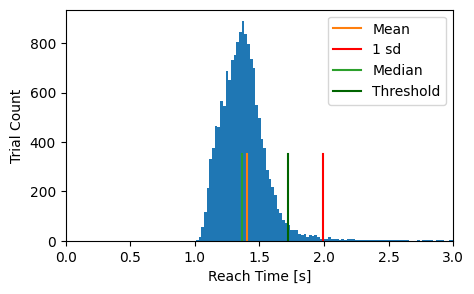

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.hist(np.hstack(reach_times), bins=2000)
ax.set(xlim=[0, 3], xlabel='Reach Time [s]', ylabel='Trial Count')
ax.plot([np.mean(np.hstack(reach_times)), np.mean(np.hstack(reach_times))], [0, 350], label='Mean')
ax.plot([np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times)),np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times))], [0, 350],
        color='red', label='1 sd')
ax.plot([np.median(np.hstack(reach_times)), np.median(np.hstack(reach_times))], [0, 350], label='Median')
ax.plot([reach_time_thresh, reach_time_thresh], [0, 350], color='darkgreen', label='Threshold')
plt.legend()
plt.show()

## Plot behavioral data

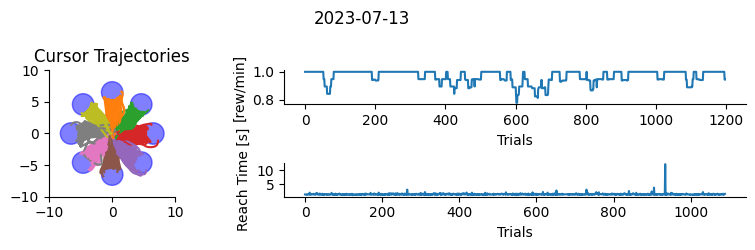

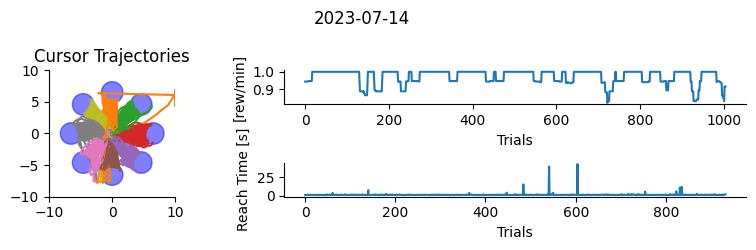

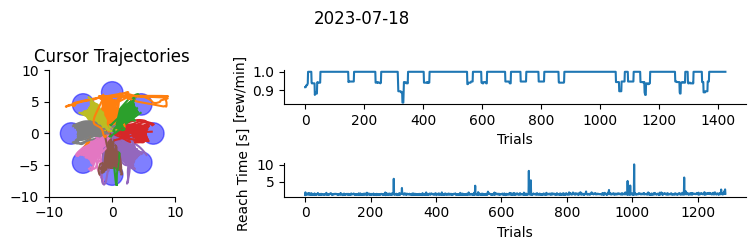

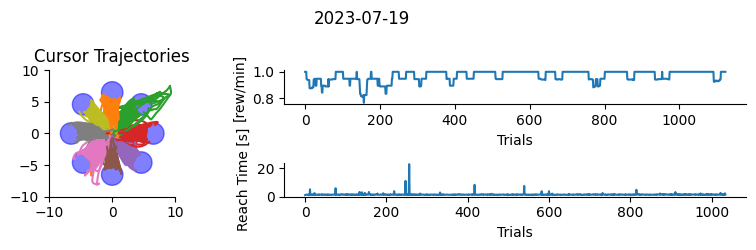

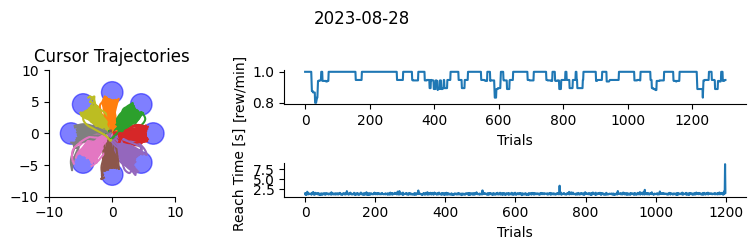

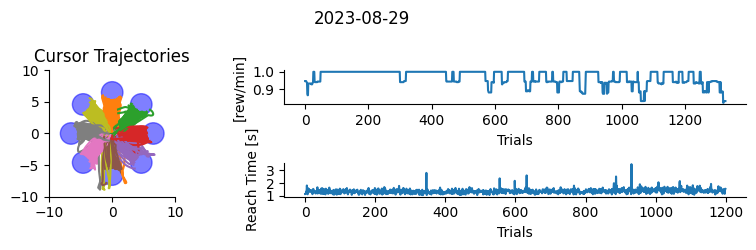

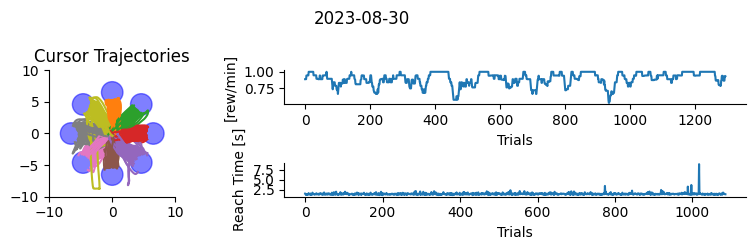

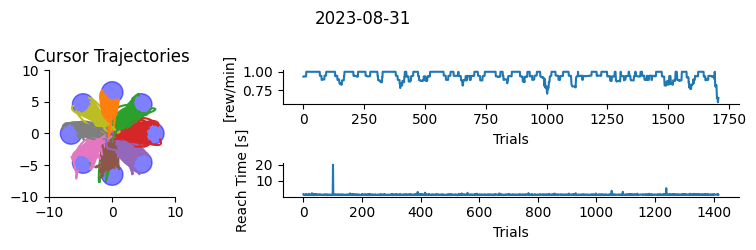

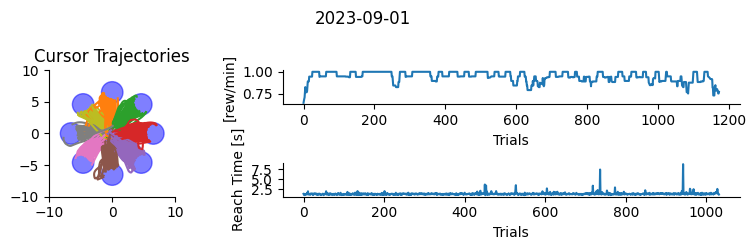

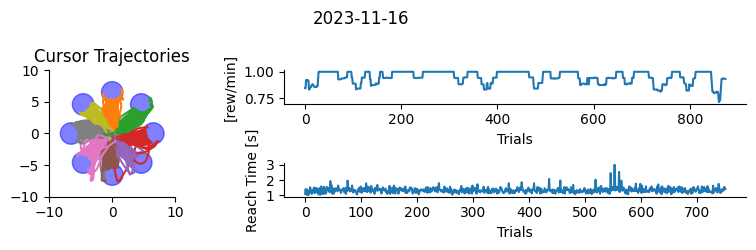

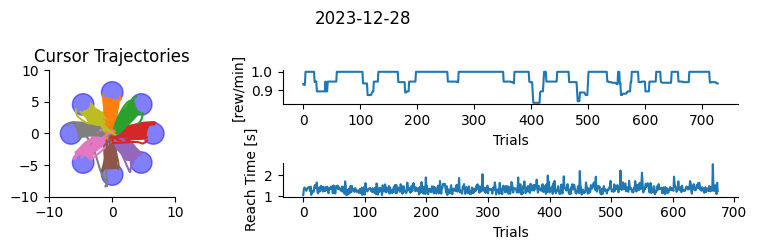

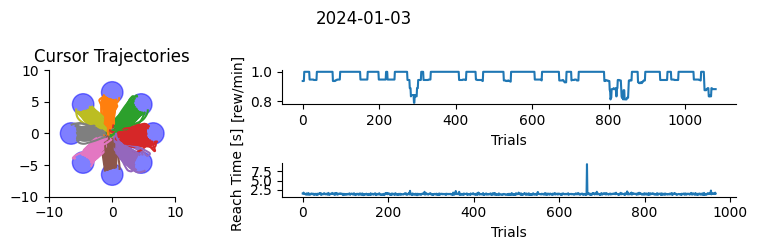

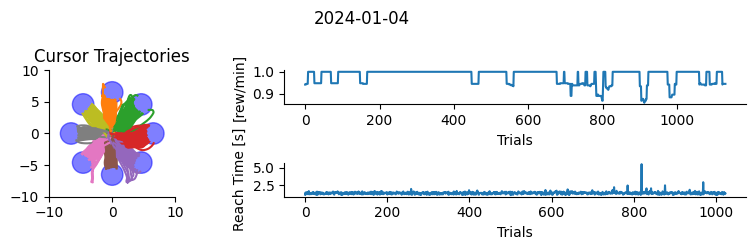

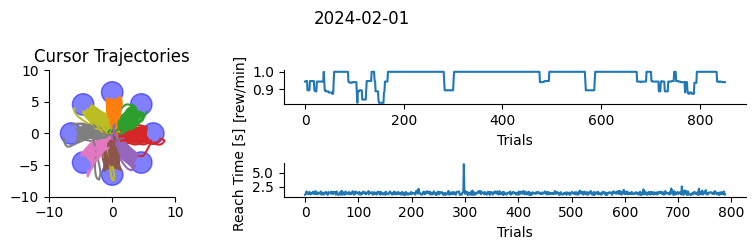

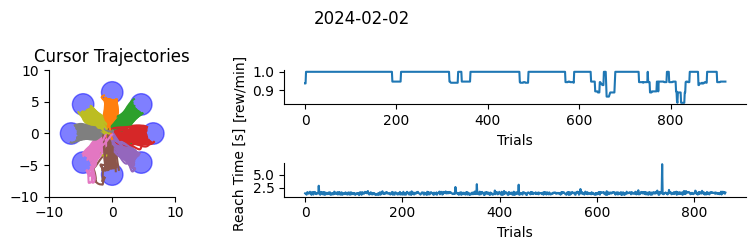

In [10]:
# All trials
samplerate = 1000
go_cue_idx = np.ceil((df['go_cue_time'] - df['start_time'])*samplerate).astype(int)
trial_end_idx = np.ceil((df['reach_end_time'] - df['start_time'])*samplerate).astype(int)
for idate, date in enumerate(dates):
    
    fig, ax = plt.subplot_mosaic("ABB;ACC",figsize=(8,2.5))
    labels=np.array(df['target_idx'][df['date']==date])
    traj = [temp_traj[np.array(go_cue_idx[df['date']==date])[itraj]:np.array(trial_end_idx[df['date']==date])[itraj],:] for itraj, temp_traj in enumerate(df['cursor_traj'][df['date']==date])]
    aopy.visualization.color_trajectories(traj, labels, colors=colors, ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, df['target_radius'][0], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot success rate
    # ax['B'].plot(np.arange(success_rate_window/2, n_mctrials[idate]-(success_rate_window/2)+1), success_rate[idate])
    ax['B'].plot(np.arange(success_rate[success_rate_date_labels==date].shape[0]), success_rate[success_rate_date_labels==date])
    ax['B'].set(xlabel='Trials', ylabel='[rew/min]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    # Plot reach time
    ax['C'].plot(np.array(df['duration'][df['date']==date]))
    ax['C'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['C'].spines.right.set_visible(False)
    ax['C'].spines.top.set_visible(False)
    plt.suptitle(date)
    fig.tight_layout()
    plt.show()
    # if save_figs:
    #     aopy.visualization.savefig(full_save_dir, subject+'_mc_behavior.svg')   

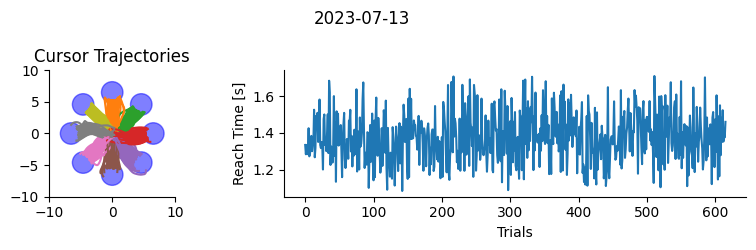

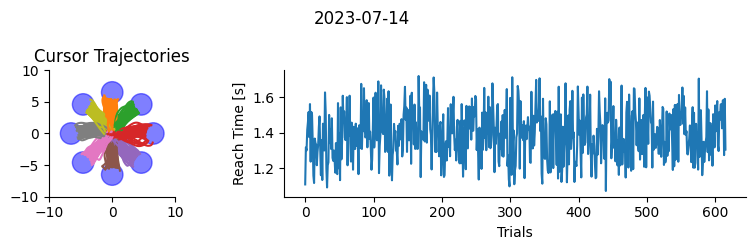

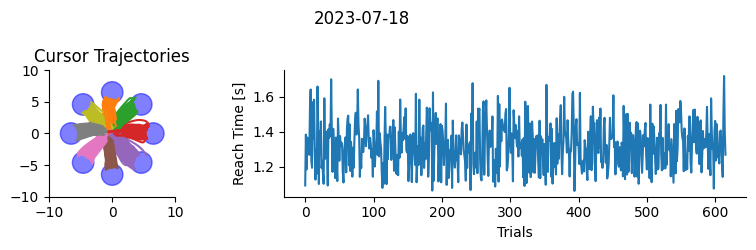

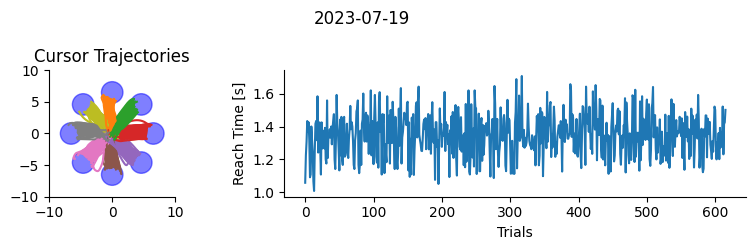

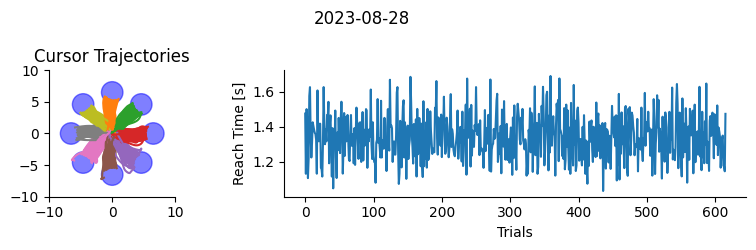

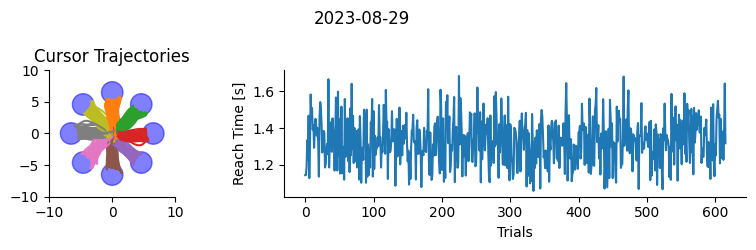

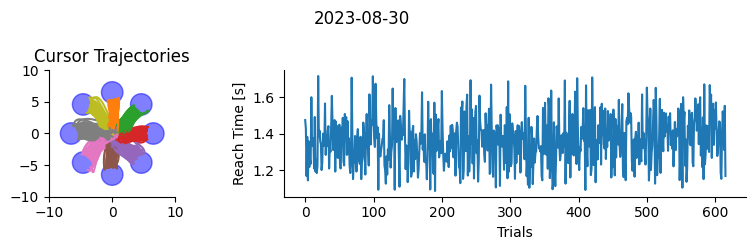

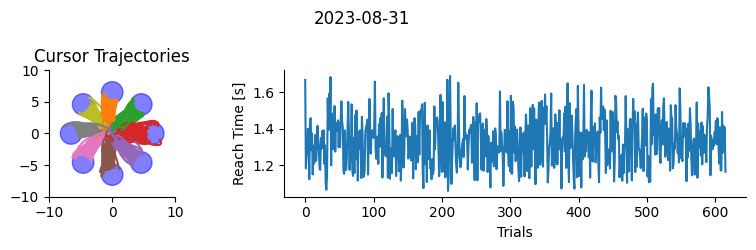

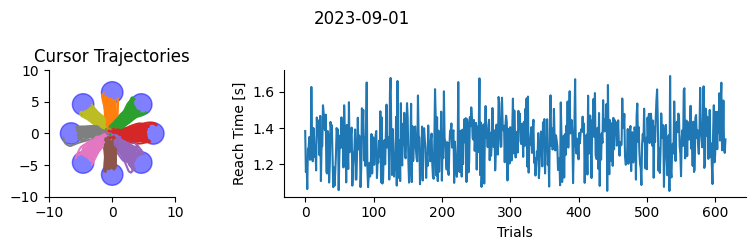

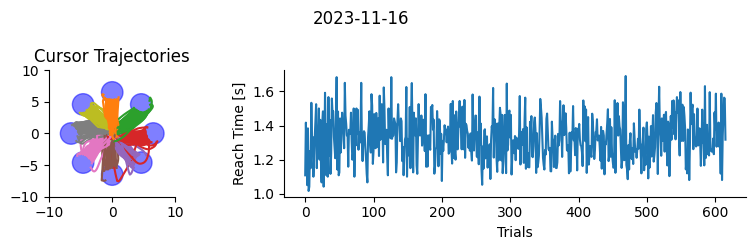

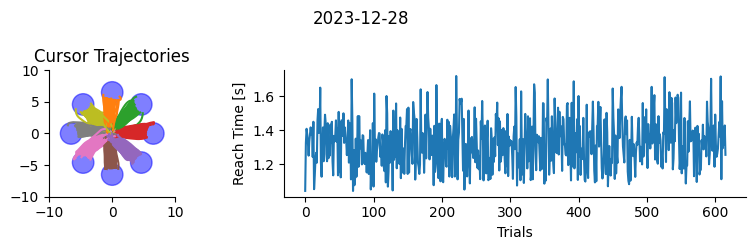

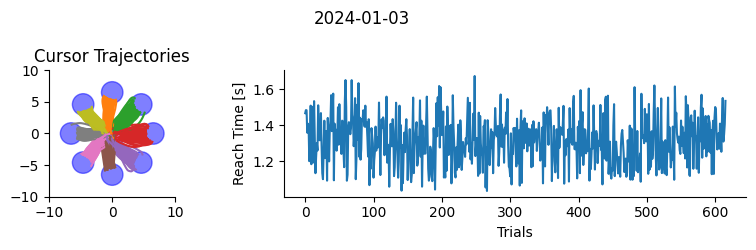

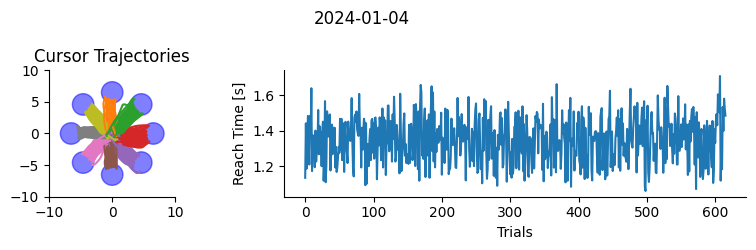

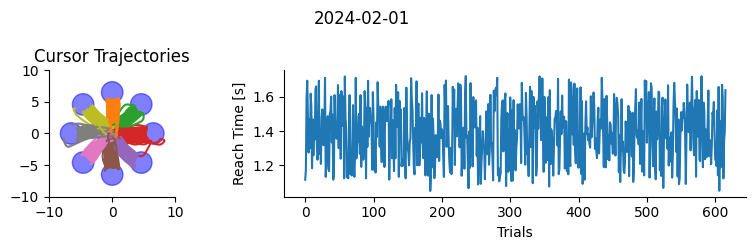

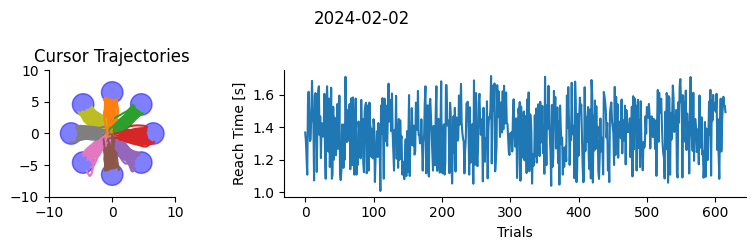

In [11]:
# With bad trials removed from trajectories and reach times.
# cursor_traj_clean = [[traj for itraj, traj in enumerate(df['cursor_traj'][df['date']==date]) if good_trial_idx[idate][itraj]] for idate, date in enumerate(dates)]
for idate, date in enumerate(dates):
    fig, ax = plt.subplot_mosaic("ABB",figsize=(8,2.5))
    labels=np.array(df['target_idx'][df['date']==date])[df['good_trial'][df['date']==date]].astype(int)
    style = plt.cycler(color=[colors[i] for i in labels])
    ax['A'].set_prop_cycle(style)
    traj = [temp_traj[np.array(go_cue_idx[(df['date']==date)*df['good_trial']])[itraj]:np.array(trial_end_idx[(df['date']==date)*df['good_trial']])[itraj],:] for itraj, temp_traj in enumerate(df['cursor_traj'][(df['date']==date)*df['good_trial']])]
    aopy.visualization.plot_trajectories(traj,  ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, df['target_radius'][0], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot reach time
    ax['B'].plot(np.array(df['duration'][df['date']==date])[df['good_trial'][df['date']==date]])
    ax['B'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    plt.suptitle(date)
    fig.tight_layout()
    plt.show()

# Load neuropixel data

In [12]:
def tabulate_neuropixel_data(preproc_dir, subjects, ids, dates, trigger_times, datatype, spike_bin_width, metadata=[], df=None):
    '''
    Automatically returns recording site, neuropixel implant type, 
    '''
    if df is None:
        df = pd.DataFrame()
    
    entries = list(zip(subjects, dates, ids))
    for subject, date, te in tqdm(entries): 
    
            # Load data
        # exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, me.id, me.date.date())
        filename_mc = aopy.data.get_preprocessed_filename(subject, te, date, 'ap')
        try:
            if datatype == 'ap':
                ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')
            elif datatype == 'lfp':
                ...
            else:
                print('Please enter a valid datatype (ap or lfp)')
                return
            ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'metadata')

        except:
            print(f"Could not load data from date: {date}, te:{te}")
            continue
        
        unit_labels
        spike_times
        recording_site
        implant_name
        spike_pos

In [13]:
ntime = np.round((tafter_mc + tbefore_mc)/spike_bin_width_mc).astype(int)
trial_time_axis = np.arange(-tbefore_mc, tafter_mc, spike_bin_width_mc)
ntargets = len(np.unique(df['target_idx']))

In [14]:
# Concatenate trials across sessions within a day
# TODO: concatenatmc_entries if recorded at the same stim site but during different days
start = time.time()
spike_times = []
unit_labels = []
trial_times = []
spike_segs = []
spike_align = []
spike_align_raster = []
spike_labels = []
spike_pos = []
ks_labels = []
recording_site = []
implant_name = []
df['recording_site'] = 0
df['implant_name'] = ''

for ime, me in enumerate(tqdm(mc_entries)):

    ########################################################
    ### FUNCTION 1 - concatenate spike times across sessions
    ########################################################

    # Load data from sessions recorded on the same day and combine 
    # Load data
    exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, me.id, me.date.date())
    filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'ap')
    try:
        ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')
        ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'metadata')

    except:
        print(f"Could not load data. (TE: {me.id}, Date: {me.date.date()})")
        continue
        
    samplerate = exp_metadata['cursor_interp_samplerate']    
    
    ########################################################
    
    unit_labels.append(ap_data['unique_label'])
    spike_times.append(ap_data['unit']) # Assumes spike labels are consistent across recording sessions (works if recorded on the same day, but otherwise it does not)
    spike_pos.append(ap_data['pos'])
    df.loc[df['te_id']==me.id, ['recording_site']] = exp_metadata['neuropixel_port1_site']
    df.loc[df['te_id']==me.id, ['implant_name']] = exp_metadata['neuropixel_port1_drive_type']
    # df['recording_site'][df['te_id']==me.id] = exp_metadata['neuropixel_port1_site'] # TODO: quirry this from the db instead of metadata
    # df['implant_name'][df['te_id']==me.id] = me.task_params['neuropixel_port1_drive_type']
    
    ########################################################
    
    spike_segs_day = {}
    for iunit, unitid in enumerate(ap_data['unique_label']):
        binned_spikes, time_bins = aopy.precondition.bin_spike_times(ap_data['unit'][str(unitid)], 0, np.array(df['reach_end_time'][df['te_id']==me.id])[-1]+20, spike_bin_width_mc)

        # Align trial segments
        spike_segs_day[str(unitid)] = aopy.preproc.base.get_data_segments(binned_spikes, traj_times[df['te_id']==me.id,:], 1/spike_bin_width_mc)
        # spike_segs_day[str(unitid)] = [smooth_timeseries_gaus(data_segs[itr], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd) for itr in range(len(data_segs))]
        
    spike_segs.append(spike_segs_day)

  0%|          | 0/18 [00:00<?, ?it/s]

Could not load data. (TE: 9923, Date: 2023-07-13)
Could not load data. (TE: 9931, Date: 2023-07-14)


In [15]:
# Update unit labels for each trial
unique_ids = np.unique(df['te_id'])
unit_label_list_4df = []
for itrial in range(len(df)):
    trial_te_id = df['te_id'][itrial]
    ite_id = np.where(unique_ids==trial_te_id)[0][0]
    unit_label_list_4df.append(unit_labels[ite_id])
df['unit_labels'] = pds.Series(unit_label_list_4df)

In [16]:
# Combine unit labels for sessions recorded on the same day
for idate, date in enumerate(np.unique(df['date'])):
    # Only necessary if there are multiple TEs from the dame day
    nsessions_day = len(np.unique(df['te_id'][df['date']==date])) 
    if nsessions_day > 1:
        # Get times from the first session to add to.
        sessions_today = np.unique(df['te_id'][df['date']==date])
        baseline_times = {}
        baseline_times['unit_labels'] = np.array(df['unit_labels'][df['te_id']==sessions_today[0]])[0]

        max_time = np.array(df['reach_end_time'][df['te_id']==sessions_today[0]])[-1]
        for isess in range(1,nsessions_day):
            # Update unit labels
            unit_labels_today = np.array(df['unit_labels'][df['te_id']==sessions_today[isess]])[0]
            good_unit_label_mask = np.in1d(baseline_times['unit_labels'], unit_labels_today) # Get units from first session that are also in the second
            baseline_times['unit_labels'] = baseline_times['unit_labels'][good_unit_label_mask] # Upate list of units to keep
        
        # Update unit labels in dataframe
        for itrial in range(len(df)):
            if df['te_id'][itrial] in sessions_today:
                df.at[itrial, 'unit_labels'] = baseline_times['unit_labels']

In [17]:
# Restructure dictionaries of spike segments and save in dataframe
# Want a list each entry is a dictionary of spike segs. Each entry of the dict is a spike seg
unique_ids = np.unique(df['te_id'])
spike_seg_list_4df = []
for itrial in tqdm(range(len(df))):
    trial_te_id = df['te_id'][itrial]
    ite_id = np.where(unique_ids==trial_te_id)[0][0]
    idx_trial = itrial - np.min(np.where(df['te_id']==trial_te_id))
    spike_dict = {}
    for iunit, unitid in enumerate(list(df['unit_labels'][df['te_id']==trial_te_id])[0]): #Each TE has the same unit labels
        spike_dict[str(unitid)] = spike_segs[ite_id][str(unitid)][idx_trial]
    # print(spike_segs[ite_id][str(unitid)][idx_trial])
    spike_seg_list_4df.append(spike_dict)
    
df['spike_segs'] = spike_seg_list_4df

  0%|          | 0/15350 [00:00<?, ?it/s]

In [18]:
# Get spike_seg idx for relevant events (Also will need to get idx for kinematics)
df['delay_start_kin_idx'] = np.ceil((df['delay_start_time'] - df['start_time'])*samplerate)
df['delay_start_neural_idx'] = np.ceil((df['delay_start_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['go_cue_kin_idx'] = np.ceil((df['go_cue_time'] - df['start_time'])*samplerate)
df['go_cue_neural_idx'] = np.ceil((df['go_cue_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['reach_end_kin_idx'] = np.ceil((df['reach_end_time'] - df['start_time'])*samplerate)
df['reach_end_neural_idx'] = np.ceil((df['reach_end_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['mov_onset_kin_idx'] = 0
df['mov_onset_neural_idx'] = 0

# Calculate movement onset
for ite in np.unique(df['te_id']): # Each TE has the same target radius
    # Must start at delay_start_time 
    traj = [temp_traj[np.array(go_cue_idx[df['te_id']==ite])[itraj]:,:] for itraj, temp_traj in enumerate(df['cursor_traj'][df['te_id']==ite])]
    df.loc[df['te_id']==ite, ['mov_onset_kin_idx']] = np.array(get_cursor_leave_center_idx(traj, np.array(df['target_radius'][df['te_id']==ite])[0])) + np.array(go_cue_idx[df['te_id']==ite])
    kin_neural_samplerate_ratio = samplerate/(1/spike_bin_width_mc)
    df.loc[df['te_id']==ite, ['mov_onset_neural_idx']] = np.array(df['mov_onset_kin_idx'][df['te_id']==ite])//kin_neural_samplerate_ratio

## Plot a few rasters 

In [19]:
def compile_raster(data, trigger_idx, tbefore, tafter, samplerate, unit_data=False, smooth=False):
    '''
    args:
        data(ntrial-list of data dict): Each element of the list is a dictionary with each entry being a (nt) array of binned spikes
        trigger_time (ntrial):
        tbefore (float):
        tafter (float):
        unit_data (bool): If data is labelled units
        samplerate (int): neural data samplerate
    '''
    
    idx_before = int(np.ceil(tbefore*samplerate))
    idx_after = int(np.ceil(tafter*samplerate))    
    ntrials = len(data)
    ntime = int(idx_before+idx_after)
    
    if unit_data:
        unique_unit_labels = np.sort(np.unique([list(itrial_data.keys()) for itrial_data in data]).astype(int))
        nunits = len(unique_unit_labels)
        raster_array = np.zeros((ntime, ntrials, nunits))*np.nan
    else:
        unique_unit_labels = None
        raster_array = np.zeros((ntime, ntrials, data[0].shape[1]))*np.nan
    
    for itrial in range(ntrials):
        start_idx = int(trigger_idx[itrial]-idx_before)
        end_idx = int(trigger_idx[itrial]+idx_after)
        raster_idx_start = int(0)
        raster_idx_end = ntime
        
        if unit_data:
            trial_len = len(data[itrial][str(unique_unit_labels[0])])
        else:
            trial_len = data[itrial].shape[0]
        
        # Contingency if start_idx < 0 or end_idx is longer than the data segment
        if start_idx < 0:
            print('start_idx < 0')
            raster_idx_start = -start_idx
            start_idx = 0
            
        if end_idx > trial_len:
            print('end_idx < trial_len')
            trial_len = len(data[itrial][str(unique_unit_labels[0])])
            raster_idx_end = int(trial_len - trigger_idx[itrial] + idx_before)
            end_idx = trial_len

        if unit_data:
            for iunit, unit_label in enumerate(unique_unit_labels):
                if smooth:
                    # [smooth_timeseries_gaus(data_segs[itr], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd) for itr in range(len(data_segs))]
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = smooth_timeseries_gaus(data[itrial][str(unit_label)], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd)[start_idx:end_idx]
                else:
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = data[itrial][str(unit_label)][start_idx:end_idx]
                    
        else:
            raster_array[raster_idx_start:raster_idx_end,itrial,:] = data[itrial][start_idx:end_idx,:]
            
    return raster_array, unique_unit_labels

In [20]:
# Create trial aligned arrays to go cue from spike segments on each day.
rasters = {}
rasters['neural'] = {}
rasters['cursor_pos'] = {}
rasters['cursor_velo'] = {}
rasters['neural']['TARGET ONSET'] = []
rasters['neural']['GO CUE'] = []
rasters['neural']['MOVEMENT ONSET'] = []
rasters['cursor_pos']['TARGET ONSET'] = []
rasters['cursor_pos']['GO CUE'] = []
rasters['cursor_pos']['MOVEMENT ONSET'] = []
rasters['cursor_velo']['TARGET ONSET'] = []
rasters['cursor_velo']['GO CUE'] = []
rasters['cursor_velo']['MOVEMENT ONSET'] = []
for idate, date in enumerate(tqdm(dates)):
    rasters['neural']['TARGET ONSET'].append(compile_raster(list(df['spike_segs'][df['date']==date]), np.array(df['delay_start_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    rasters['neural']['GO CUE'].append(compile_raster(list(df['spike_segs'][df['date']==date]), np.array(df['go_cue_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    rasters['neural']['MOVEMENT ONSET'].append(compile_raster(list(df['spike_segs'][df['date']==date]), np.array(df['mov_onset_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    
    rasters['cursor_pos']['TARGET ONSET'].append(compile_raster(list(df['cursor_traj'][df['date']==date]), np.array(df['delay_start_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_pos']['GO CUE'].append(compile_raster(list(df['cursor_traj'][df['date']==date]), np.array(df['go_cue_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_pos']['MOVEMENT ONSET'].append(compile_raster(list(df['cursor_traj'][df['date']==date]), np.array(df['mov_onset_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    
    rasters['cursor_velo']['TARGET ONSET'].append(compile_raster(list(df['cursor_vel_traj'][df['date']==date]), np.array(df['delay_start_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_velo']['GO CUE'].append(compile_raster(list(df['cursor_vel_traj'][df['date']==date]), np.array(df['go_cue_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_velo']['MOVEMENT ONSET'].append(compile_raster(list(df['cursor_vel_traj'][df['date']==date]), np.array(df['mov_onset_kin_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    

  0%|          | 0/15 [00:00<?, ?it/s]

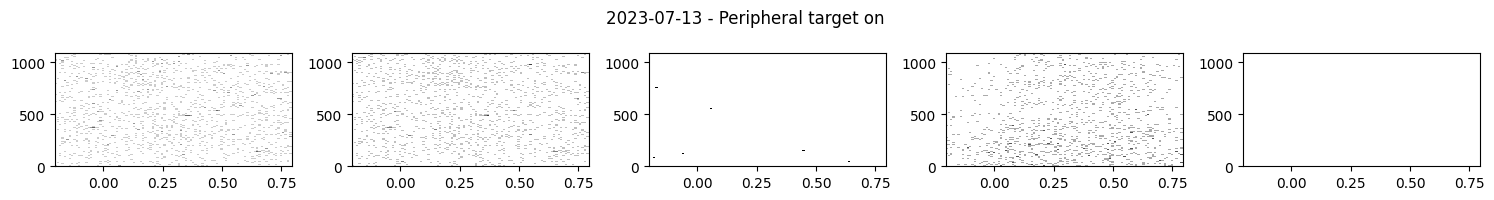

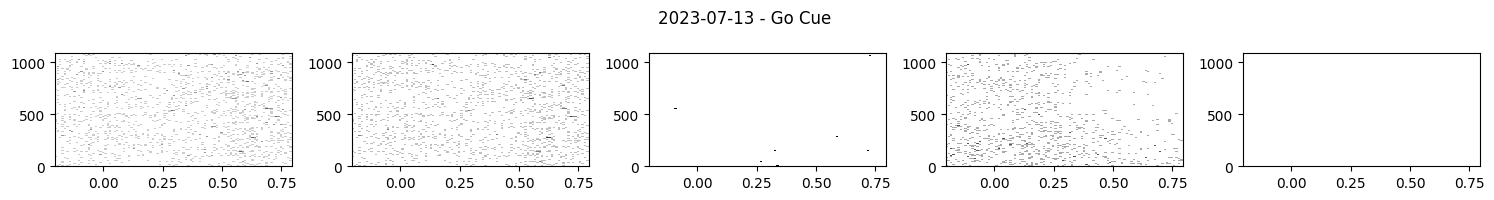

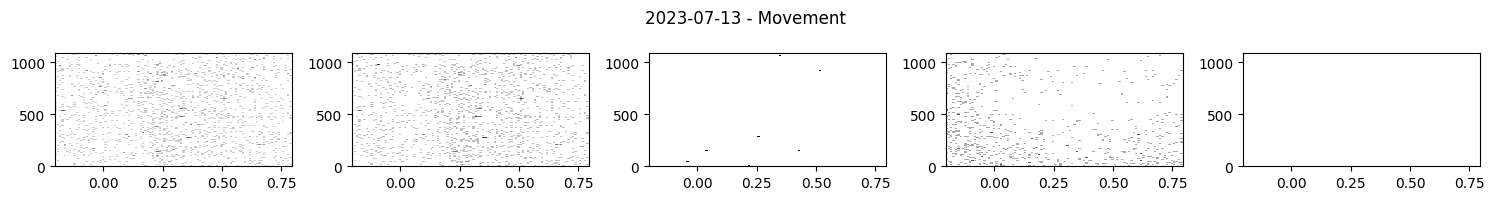

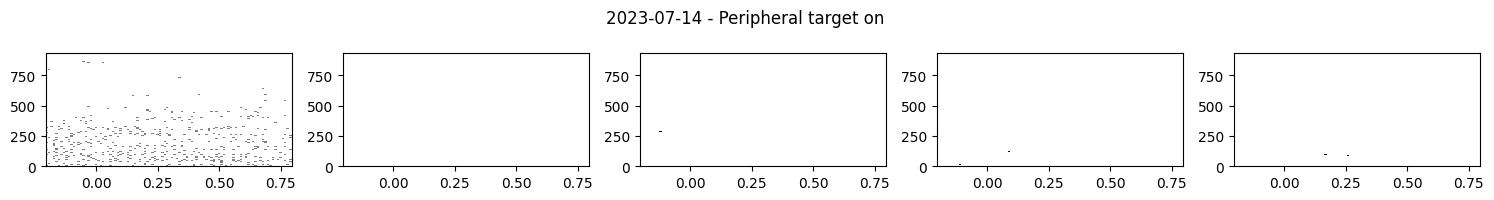

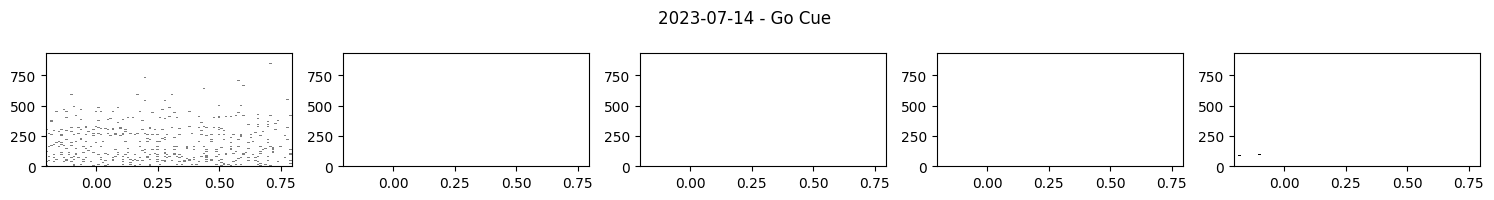

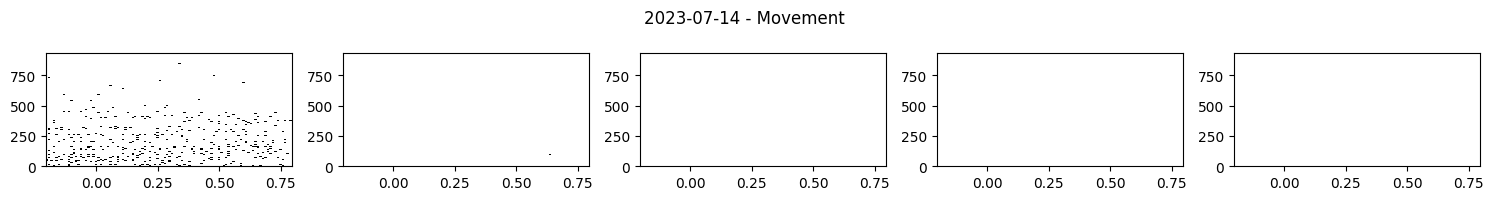

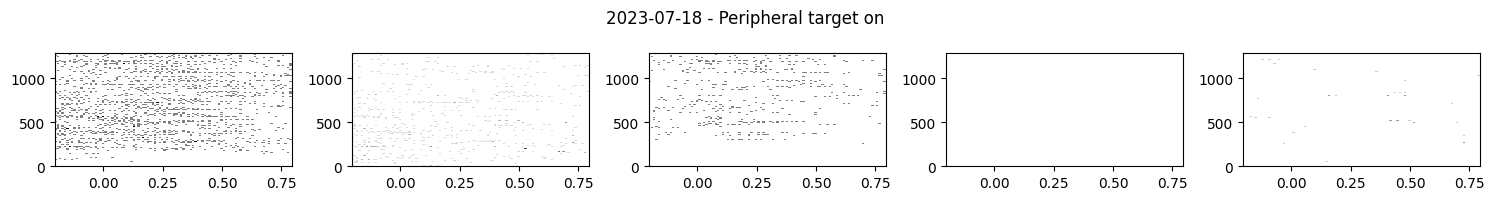

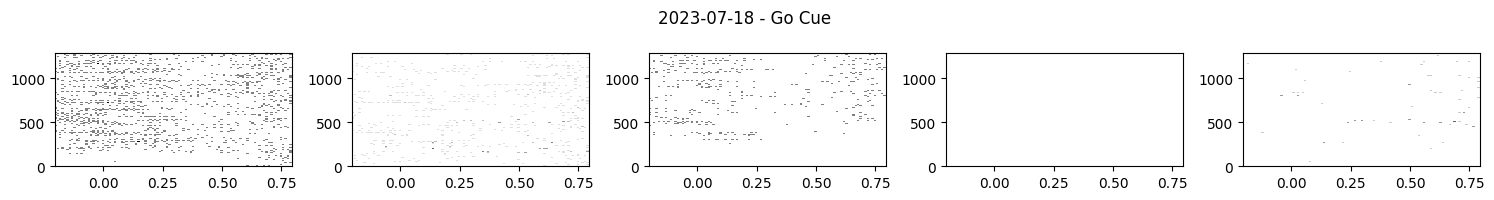

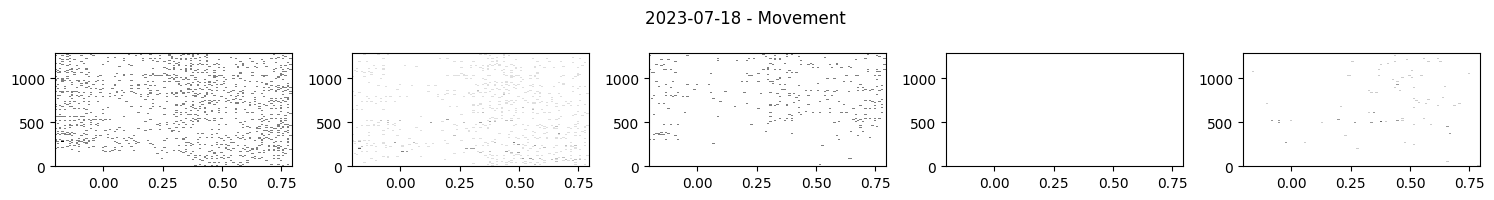

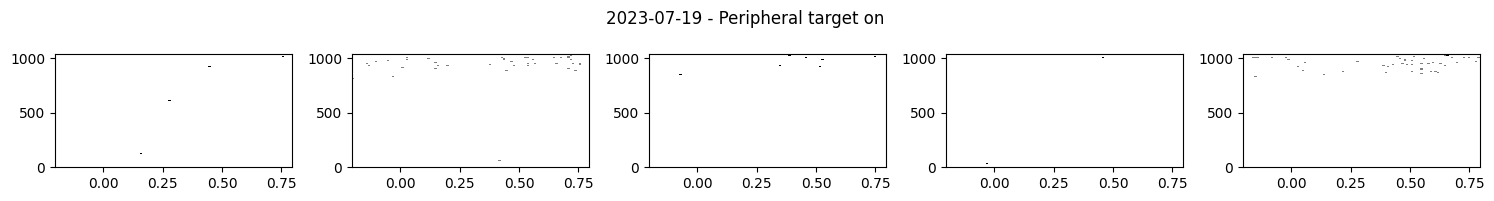

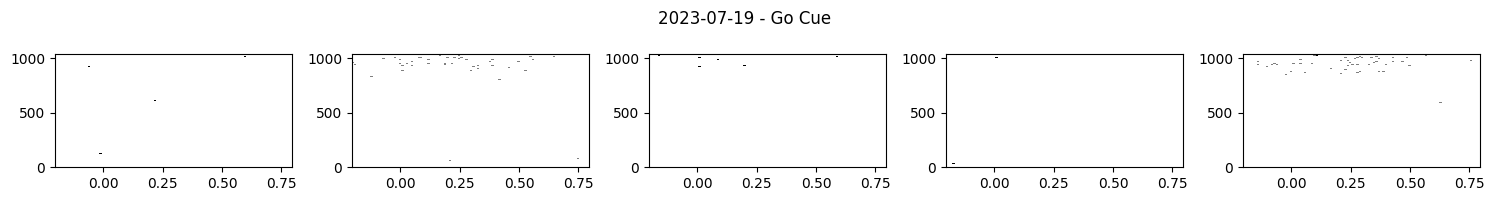

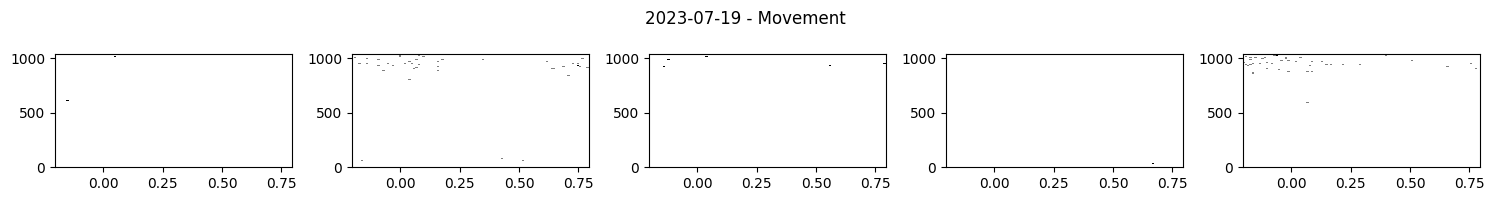

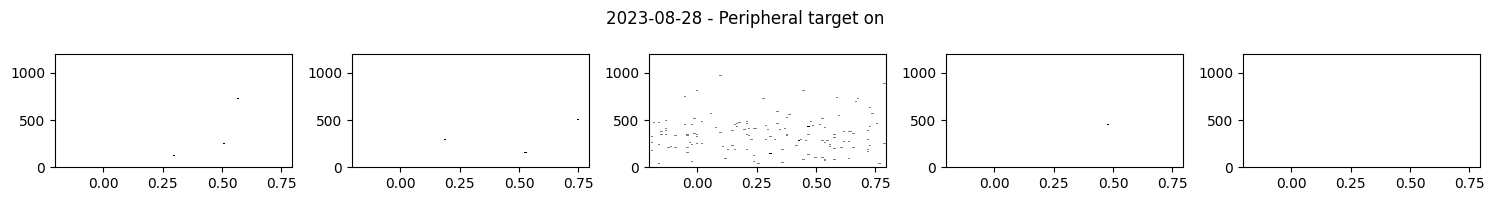

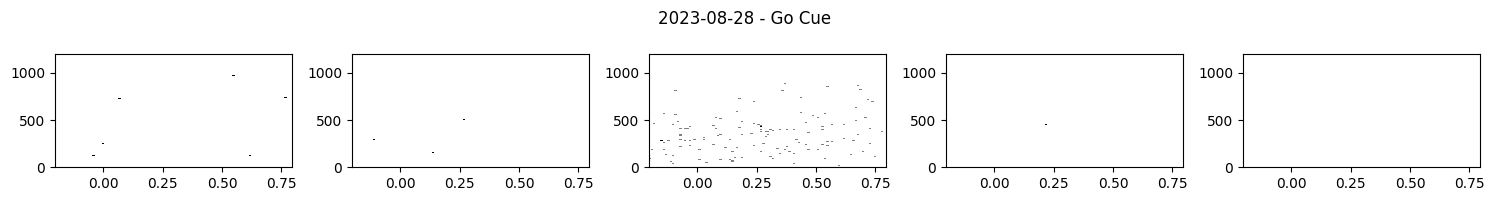

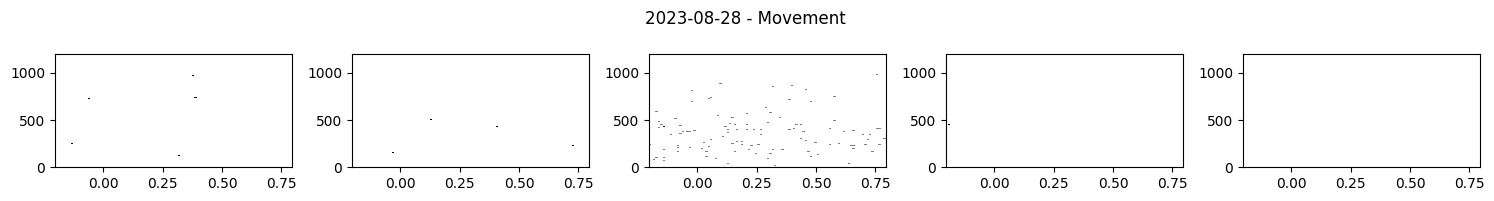

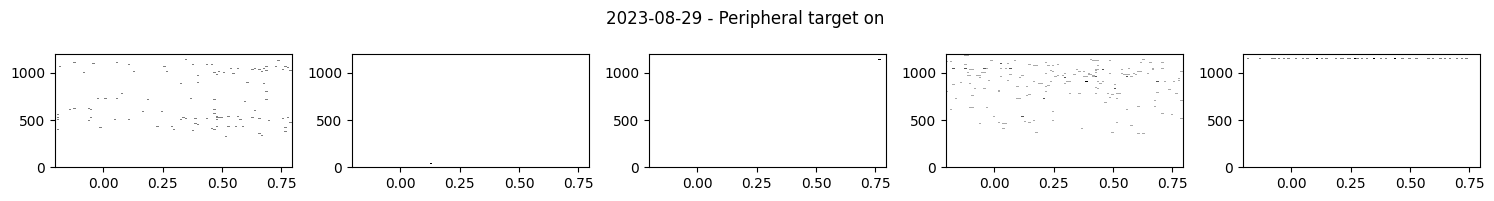

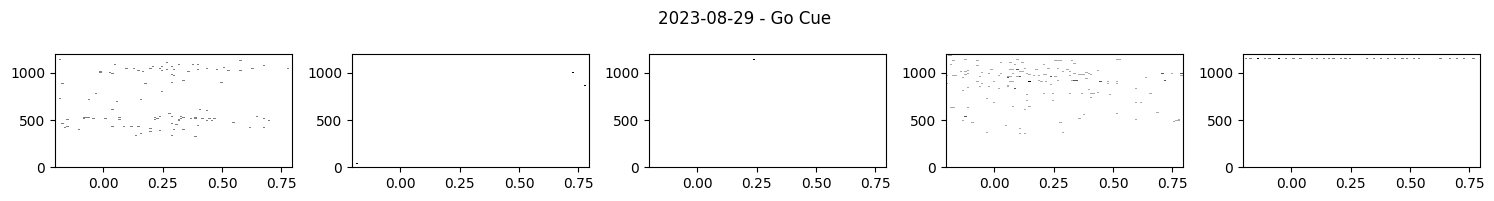

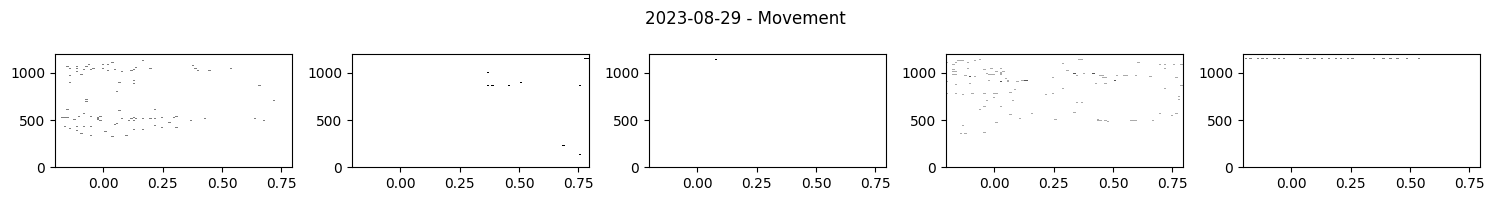

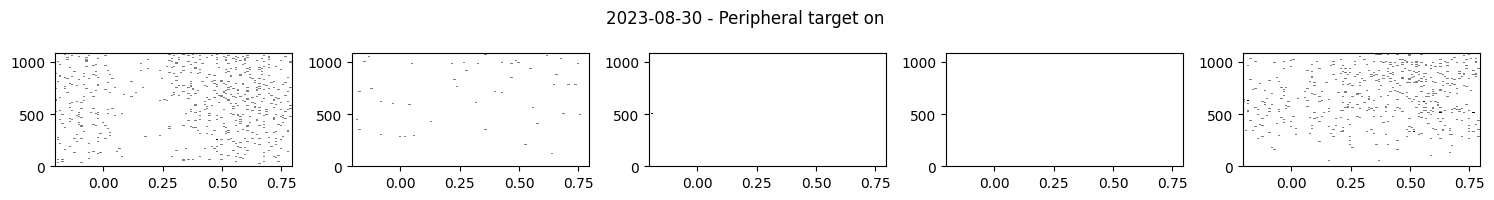

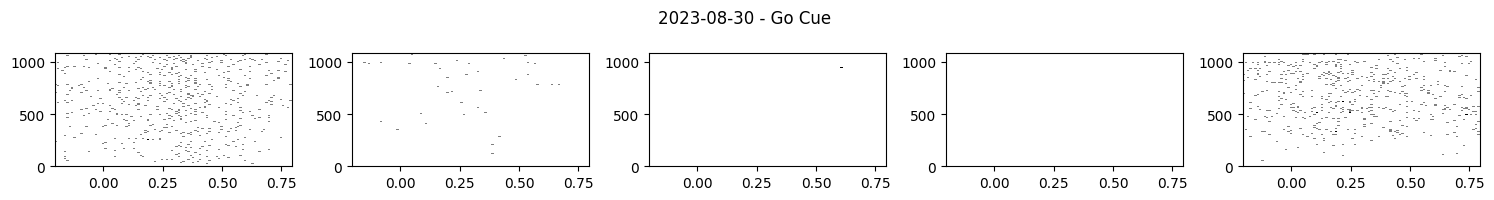

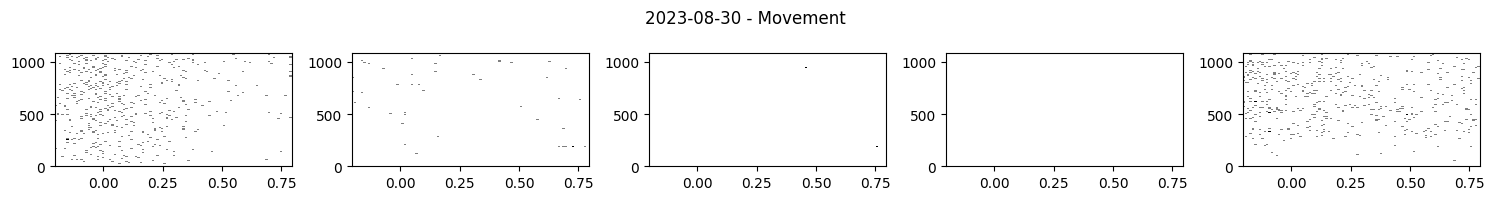

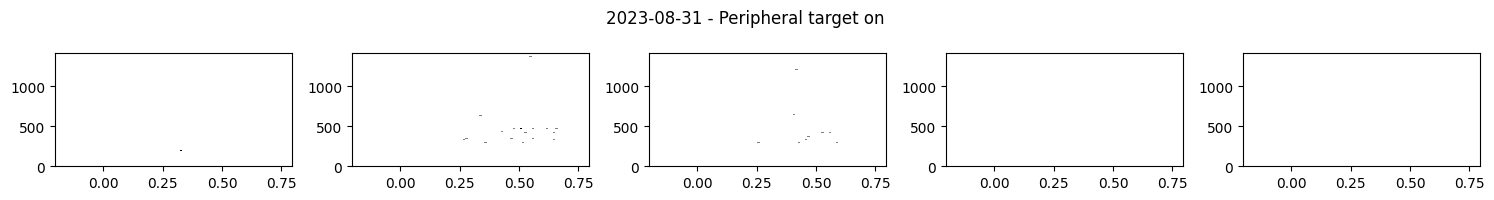

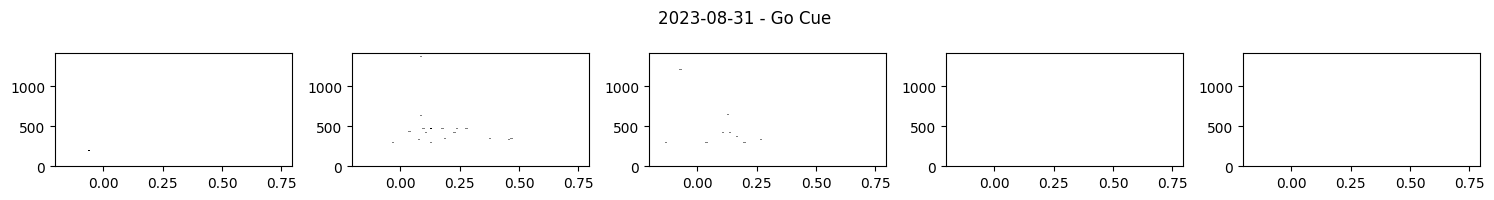

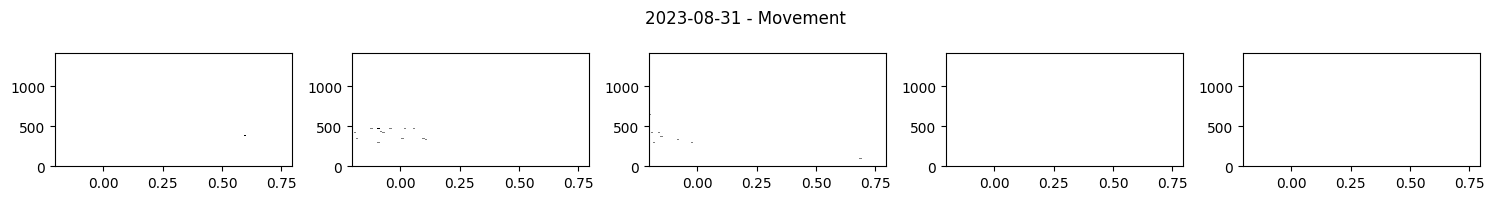

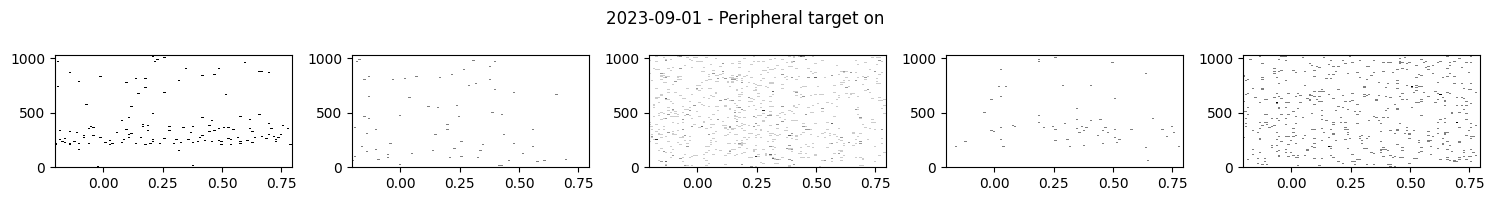

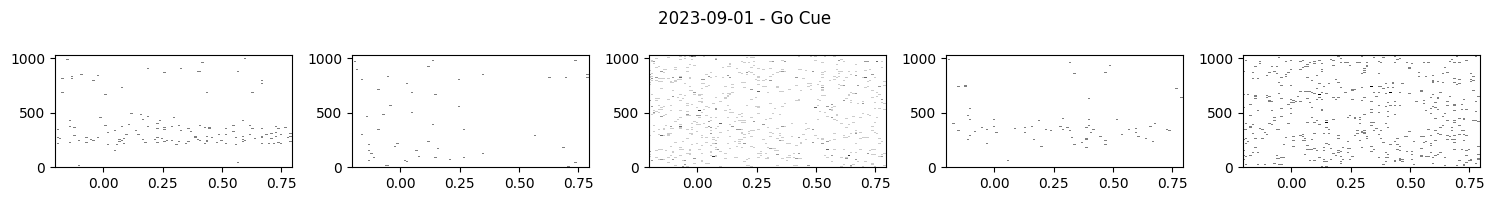

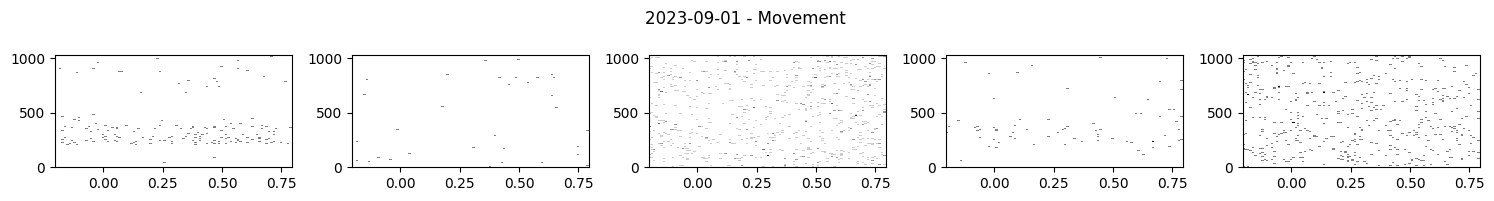

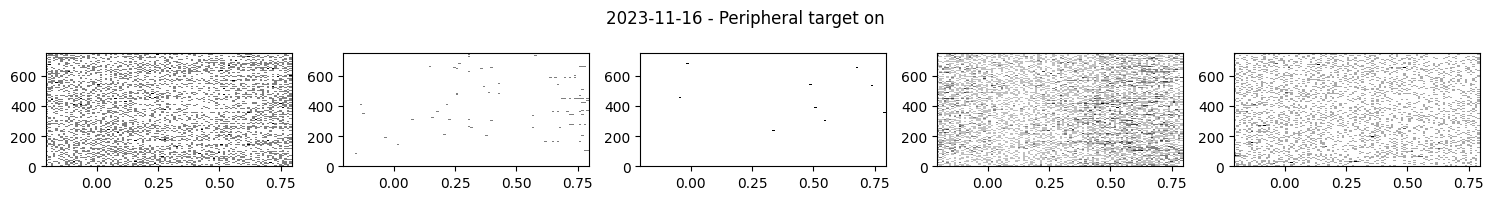

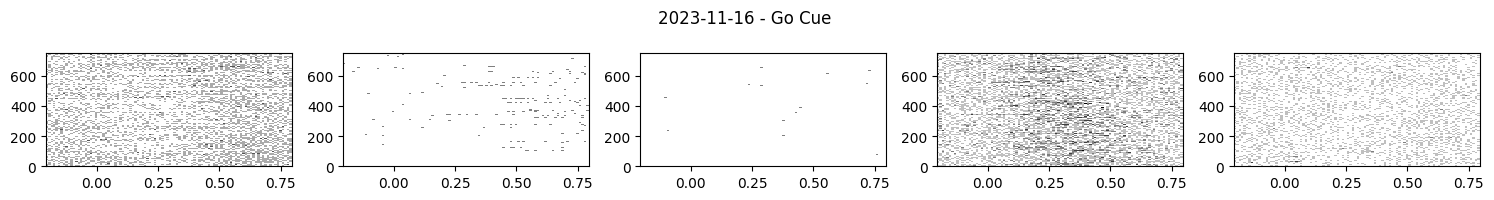

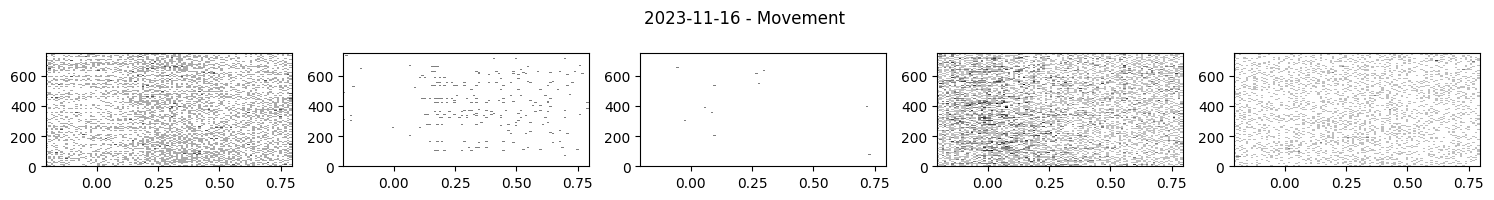

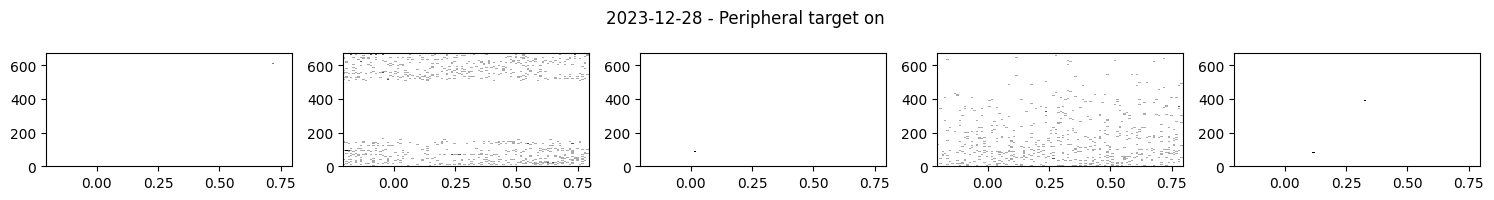

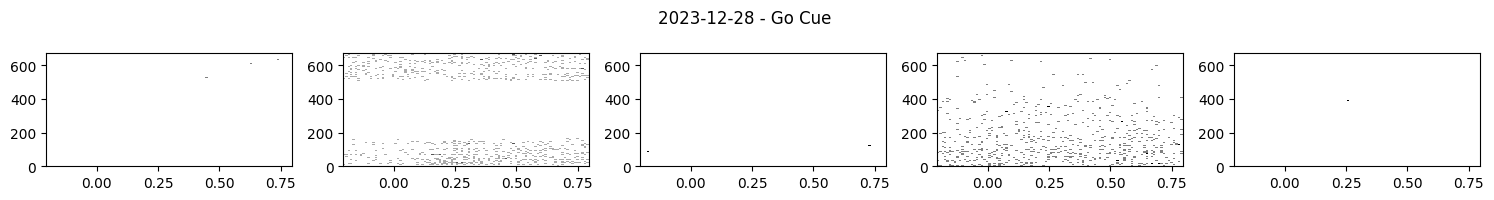

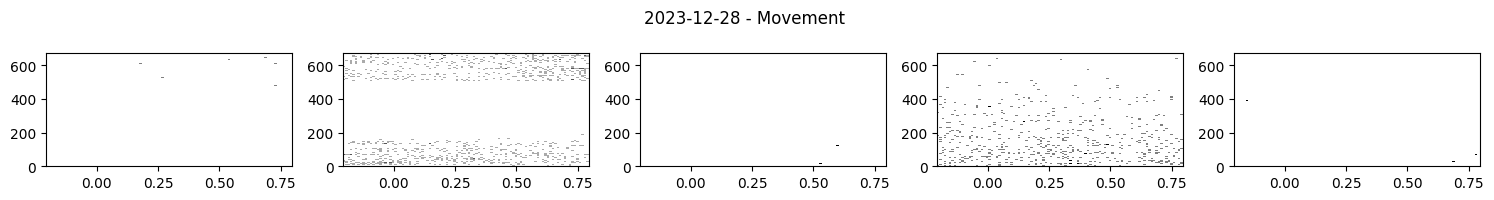

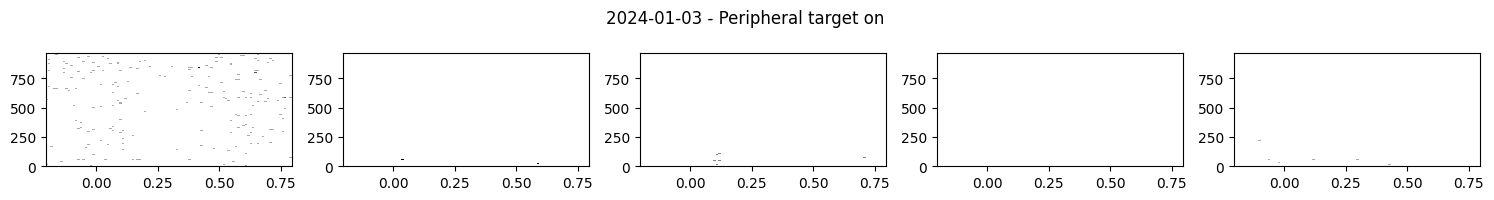

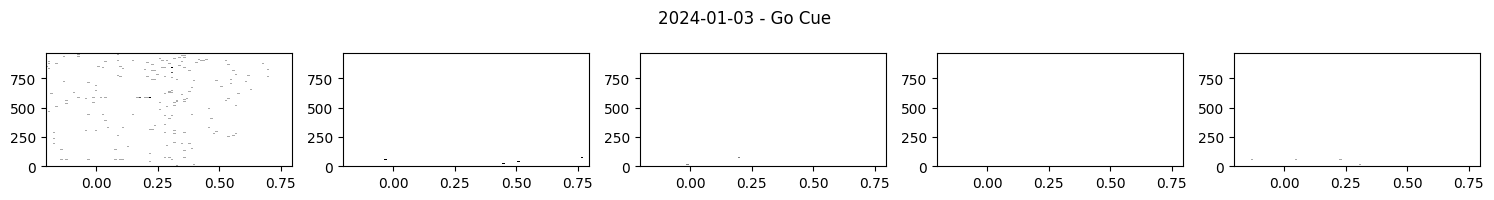

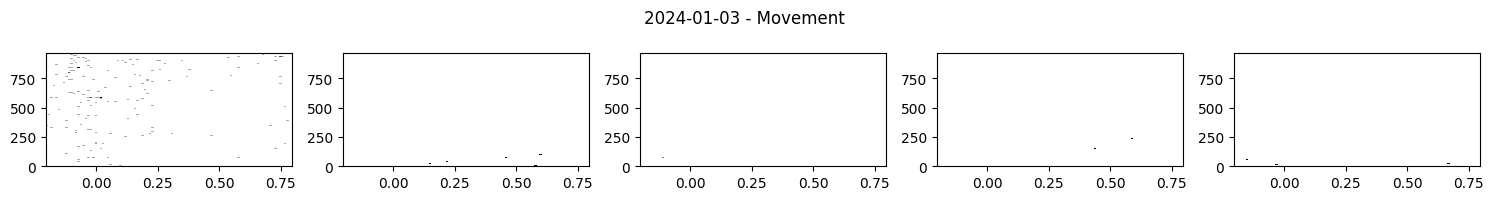

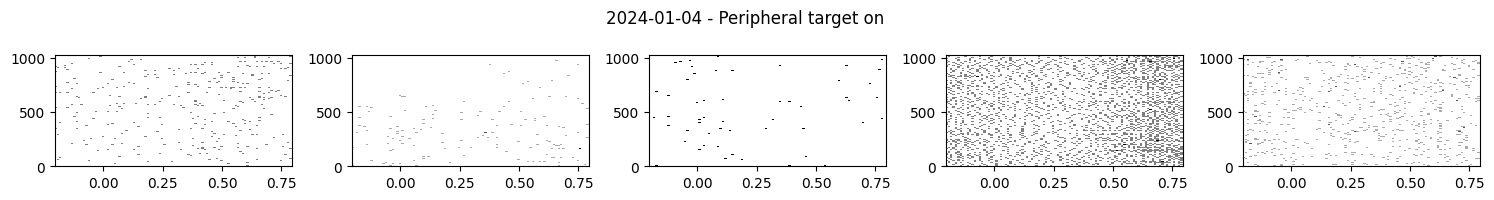

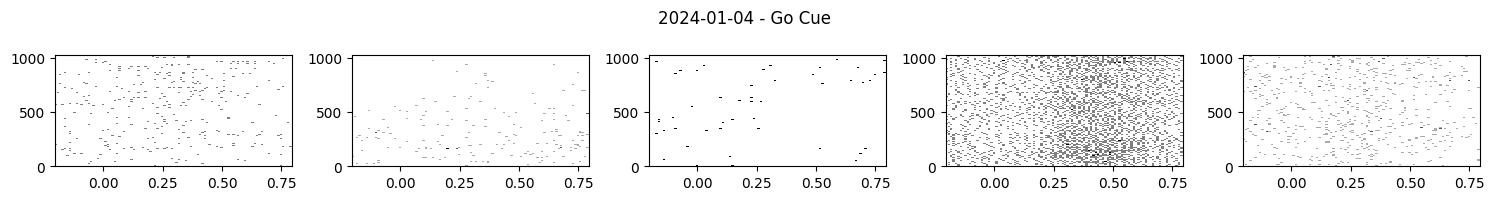

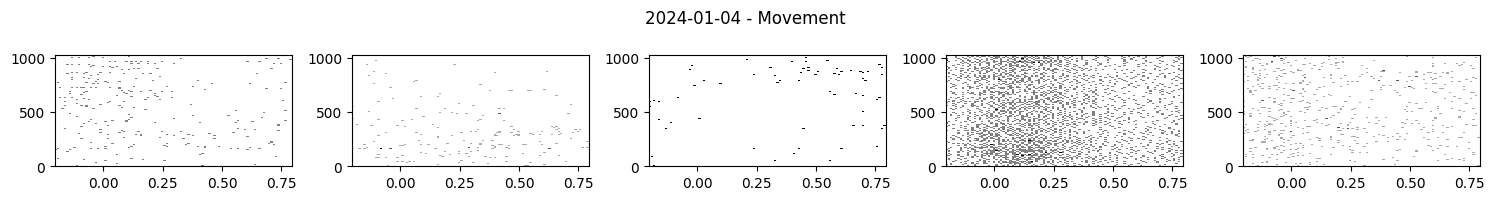

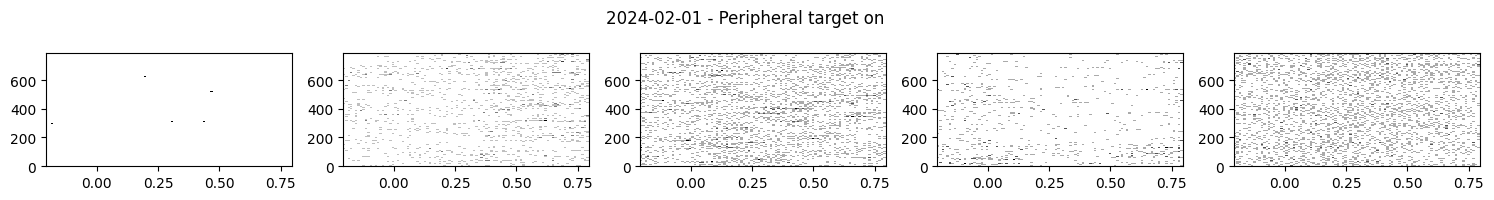

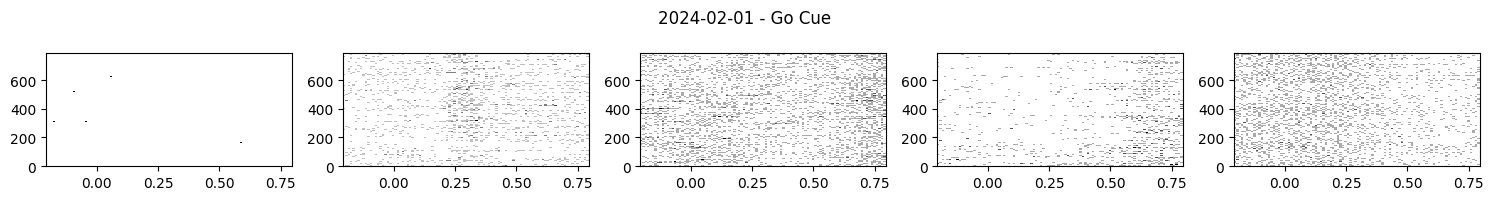

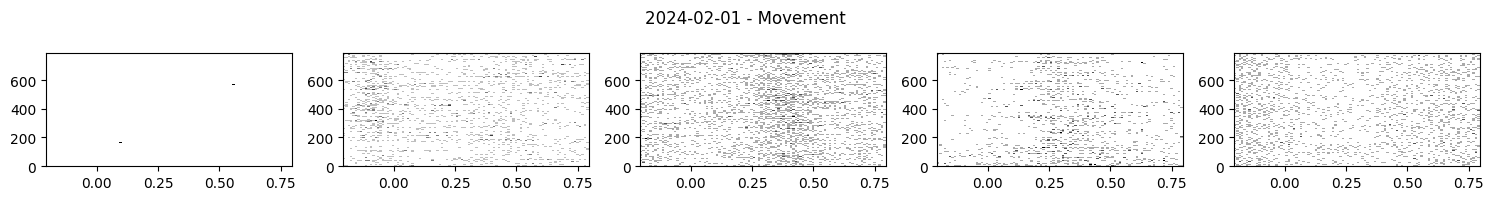

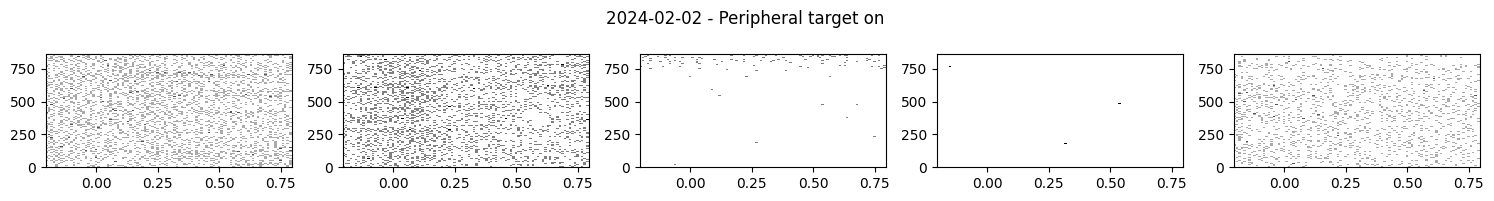

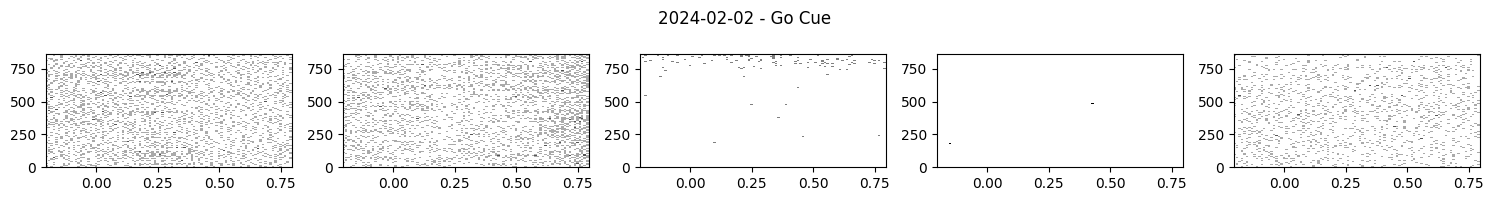

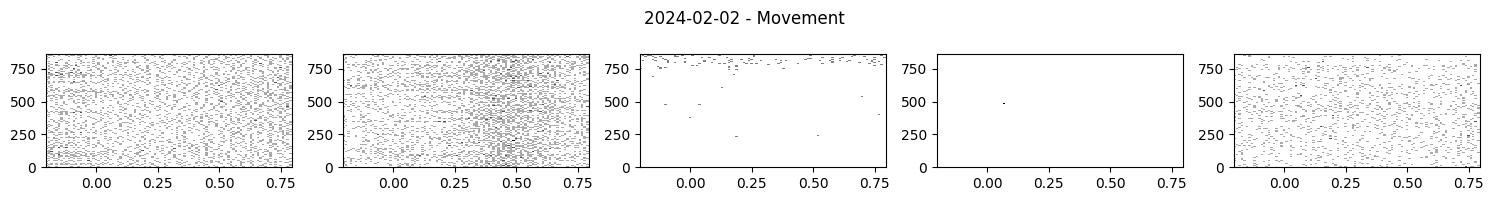

In [21]:
nrasters = 5 # Rasters of how many units to plot
for idate, date in enumerate(dates):
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['TARGET ONSET'][idate].shape[1]), rasters['neural']['TARGET ONSET'][idate][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Peripheral target on")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['GO CUE'][idate].shape[1]), rasters['neural']['GO CUE'][idate][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Go Cue")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['MOVEMENT ONSET'][idate].shape[1]), rasters['neural']['MOVEMENT ONSET'][idate][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Movement")
    fig.tight_layout()
    plt.show()


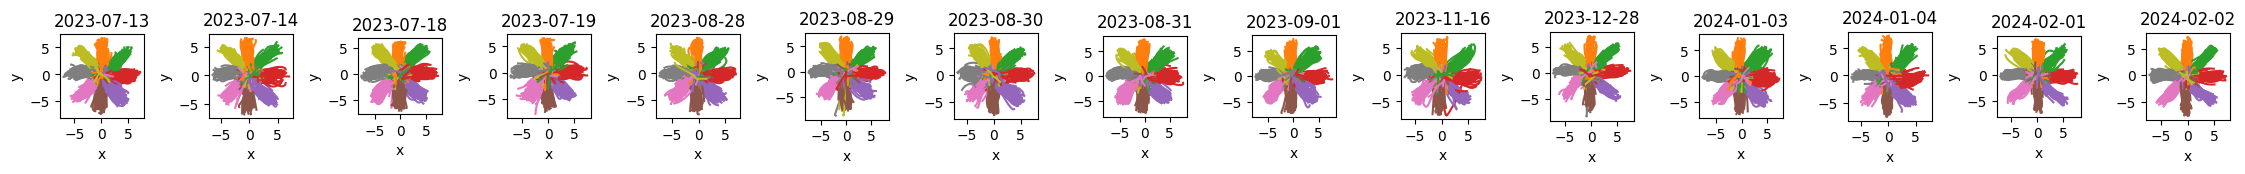

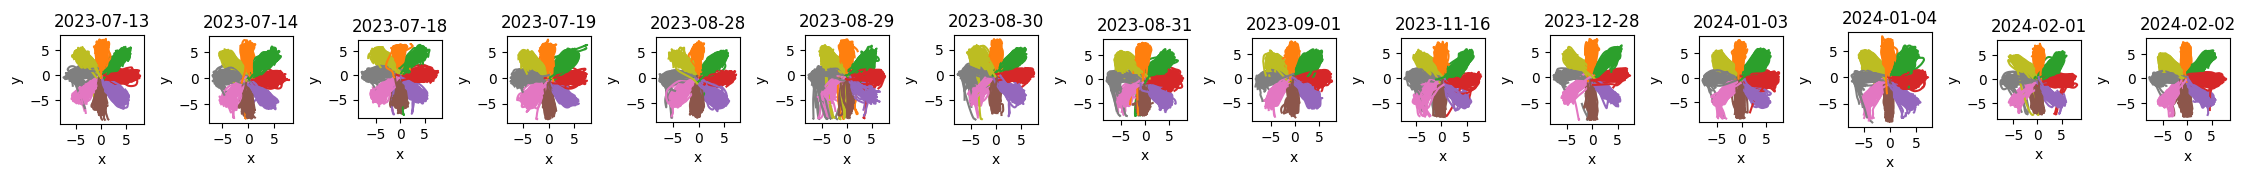

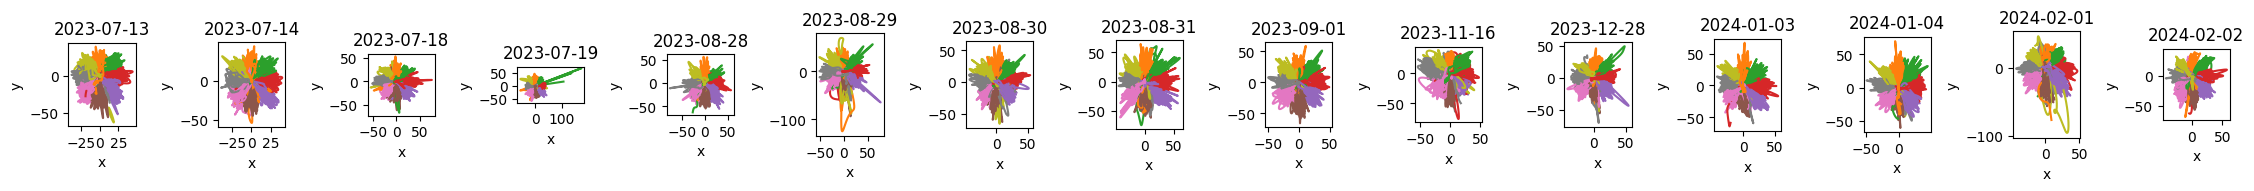

In [22]:
## Plot rasters of cursor pos (Plot all trials for each date)
fig, ax = plt.subplots(1,len(dates), figsize=(len(dates)*1.5, 4))
for idate, date in enumerate(dates):
    traj = [rasters['cursor_pos']['TARGET ONSET'][idate][:,itrial,:] for itrial in range(rasters['cursor_pos']['TARGET ONSET'][idate].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['date']==date]), colors=colors, ax=ax[idate])
    ax[idate].set(title=str(date))

fig.tight_layout()
plt.show()
    

fig, ax = plt.subplots(1,len(dates), figsize=(len(dates)*1.5, 4))
for idate, date in enumerate(dates):
    traj = [rasters['cursor_pos']['MOVEMENT ONSET'][idate][:,itrial,:] for itrial in range(rasters['cursor_pos']['MOVEMENT ONSET'][idate].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['date']==date]), colors=colors, ax=ax[idate])
    ax[idate].set(title=str(date))

fig.tight_layout()
plt.show()
    
    
fig, ax = plt.subplots(1,len(dates), figsize=(len(dates)*1.5, 4))
for idate, date in enumerate(dates):
    traj = [rasters['cursor_velo']['MOVEMENT ONSET'][idate][:,itrial,:] for itrial in range(rasters['cursor_velo']['MOVEMENT ONSET'][idate].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['date']==date]), colors=colors, ax=ax[idate])
    ax[idate].set(title=str(date))

fig.tight_layout()
plt.show()

# Save data

In [23]:
# # TODO replace this by querying database instead
# if recording_site[2] == 55 and recording_site[4] == 55:
#     recording_site[4] = 47
#     recording_site[2] = 56
    
# TODO replace this by querying database instead
df['recording_site'][(df['recording_site']==55)*(df['date']==dates[2])] = 56
df['recording_site'][(df['recording_site']==55)*(df['date']==dates[4])] = 47
recording_sites = np.array([np.array(df['recording_site'][df['date']==date])[0] for date in dates])
implant = np.array([np.array(df['implant_name'][df['date']==date])[0] for date in dates])
print(recording_sites)

[ 11  30  56   9  47  40  18  11   9 121  22   9 120  98  45]


/tmp/ipykernel_3113219/513858588.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recording_site'][(df['recording_site']==55)*(df['date']==dates[2])] = 56
/tmp/ipykernel_3113219/513858588.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recording_site'][(df['recording_site']==55)*(df['date']==dates[4])] = 47


In [24]:
ap_data.keys()
print(ap_data['unit'].keys())

dict_keys(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98'])


In [25]:
# neuropixel_preproc_data = {}
# neuropixel_preproc_data['spike_times'] = spike_times
# neuropixel_preproc_data['unit_labels'] = unit_labels
# neuropixel_preproc_data['trial_times'] = trial_times
# neuropixel_preproc_data['spike_align'] = spike_align # Smoothed timeseries
# neuropixel_preproc_data['spike_align_raster'] = spike_align_raster
# neuropixel_preproc_data['spike_labels'] = spike_labels
# neuropixel_preproc_data['ks_labels'] = ks_labels
# neuropixel_preproc_data['recording_site'] = recording_site
# neuropixel_preproc_data['target_idx'] = target_idx
# neuropixel_preproc_data['good_trial_idx'] = good_trial_idx
# neuropixel_preproc_data['tbefore_mc'] = tbefore_mc
# neuropixel_preproc_data['tafter_mc'] = tafter_mc
# neuropixel_preproc_data['spike_bin_width_mc'] = spike_bin_width_mc
# neuropixel_preproc_data['trial_time_axis'] = trial_time_axis
# neuropixel_preproc_data['implant'] = implant_name
# neuropixel_preproc_data['spike_pos'] = spike_pos
# neuropixel_preproc_data['mc_entries'] = mc_entries
# neuropixel_preproc_data['cursor_traj'] = cursor_traj_clean

In [26]:
preprocessing_metadata = {}
preprocessing_metadata['spike_bin_width'] = spike_bin_width_mc
preprocessing_metadata['tbefore'] = tbefore_mc
preprocessing_metadata['tafter'] = tafter_mc
preprocessing_metadata['trial_time_axis'] = trial_time_axis
preprocessing_metadata['nrecs'] = len(dates)
preprocessing_metadata['recording_sites'] = recording_sites
preprocessing_metadata['implant'] = implant
preprocessing_metadata['neural_samplerate'] = int(1/spike_bin_width_mc)
preprocessing_metadata['kin_samplerate'] = samplerate

In [27]:
start = time.time()
aopy.data.base.pkl_write(f"{subject}_np_preprocessed", (df, rasters, preprocessing_metadata), save_dir)
print(time.time()-start)

201.26911425590515


In [28]:
start = time.time()
test1, test2, test3 = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", save_dir)
print(time.time()-start)

231.92632126808167


In [29]:
print(test1.head)
print(test2.keys())
print(test3.keys())

<bound method NDFrame.head of        subject  te_id        date                    event_codes  \
0      beignet   9924  2023-07-13  [16, 80, 20, 32, 84, 48, 239]   
1      beignet   9924  2023-07-13  [16, 80, 19, 32, 83, 48, 239]   
2      beignet   9924  2023-07-13  [16, 80, 22, 32, 86, 48, 239]   
3      beignet   9924  2023-07-13  [16, 80, 24, 32, 88, 48, 239]   
4      beignet   9924  2023-07-13  [16, 80, 21, 32, 85, 48, 239]   
...        ...    ...         ...                            ...   
15345  beignet  14139  2024-02-02  [16, 80, 20, 32, 84, 48, 239]   
15346  beignet  14139  2024-02-02  [16, 80, 24, 32, 88, 48, 239]   
15347  beignet  14139  2024-02-02  [16, 80, 22, 32, 86, 48, 239]   
15348  beignet  14139  2024-02-02  [16, 80, 23, 32, 87, 48, 239]   
15349  beignet  14139  2024-02-02  [16, 80, 24, 32, 88, 48, 239]   

                                             event_times  reward penalty  \
0      [8.25708, 8.46488, 8.62348, 9.12336, 9.44004, ...    True     0.0   
1

In [30]:
print(test['mc_entries'])

NameError: name 'test' is not defined